# Intelligent Customer Support Routing Using Emotion-Aware NLP

## Imports
Libraries required for data processing, visualization, and modeling.

In [2]:
# IMPORTS

# Install missing libraries
!pip install emoji
!pip install sentence-transformers umap-learn imblearn

# Core
import re
from collections import Counter

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP / Data
import nltk
import emoji
from datasets import load_dataset
from nltk.corpus import stopwords

# Embeddings / Dimensionality reduction
from sentence_transformers import SentenceTransformer
import umap

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

# Models
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC

# Model selection / evaluation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    recall_score,
    accuracy_score,
)

# Imbalance handling
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 25.6 MB/s eta 0:00:00


In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Data Loading
Load the GoEmotions dataset and convert it into a workable DataFrame format.

In [4]:
dataset = load_dataset("go_emotions", "simplified")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

In [5]:
df_train = pd.DataFrame(dataset['train'])
df_val = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

In [6]:
stop_words = set(stopwords.words('english'))
crucial_words = {'not', 'no', 'nor', 'but', 'however', 'although', 'very', 'never'}
final_stop_words = stop_words - crucial_words

In [7]:
contractions = {
    "didn't": "did not", "don't": "do not", "aren't": "are not",
    "can't": "cannot", "couldn't": "could not", "doesn't": "does not",
    "haven't": "have not", "isn't": "is not", "won't": "will not",
    "wouldn't": "would not", "shouldn't": "should not", "wasn't": "was not",
    "weren't": "were not", "i'm": "i am", "you're": "you are", "he's": "he is",
    "it's": "it is", "we're": "we are", "they're": "they are", "let's": "let us"
}

## Data Cleaning
Prepare text data for modeling by removing noise while preserving emotional signal

In [8]:
def clean_text_professional(text):
    # 1. Bot/noise removal
    if text in ["[deleted]", "[removed]"] or pd.isna(text):
        return ""
    # 2. Lowercase
    text = text.lower()
    # 3. Expansion of Contractions
    for word, replacement in contractions.items():
        text = text.replace(word, replacement)
    # 4. Emoji Handling
    # We convert 😡 to ":enraged_face:" so the model can read it as a word.
    text = emoji.demojize(text)
    # 5. Tokenization & Cleaning
    text = re.sub(r"[^a-z0-9\s:_]", "", text)
    words = text.split()
    # 6. Stopword Removal
    filtered_words = [w for w in words if w not in final_stop_words]
    return " ".join(filtered_words)

In [9]:
df_train['clean_text'] = df_train['text'].apply(clean_text_professional)
df_val['clean_text'] = df_val['text'].apply(clean_text_professional)
df_test['clean_text'] = df_test['text'].apply(clean_text_professional)

In [10]:
# Removing empty rows caused by cleaning
df_train = df_train[df_train['clean_text'] != ""]
df_val = df_val[df_val['clean_text'] != ""]
df_test = df_test[df_test['clean_text'] != ""]

**Insight:**
Cleaning standardizes the text and reduces sparsity, which improves TF-IDF feature quality.

## Label Engineering

***The Logic:*** The raw dataset contains 27 granular emotions. For a Customer Support team, these are too specific. We aggregate them into 5 Actionable Priorities based on Business Risk:
🔴 Angry (High Risk) $\rightarrow$ Requires Senior Agent / Immediate De-escalation.
🟠 Frustrated (Churn Risk) $\rightarrow$ Requires Empathy.
🟣 Confused (Support Gap) $\rightarrow$ Requires Education/FAQ updates.
🟢 Satisfied (Retention) $\rightarrow$ Validation of good service.
🔵 Calm (Standard) $\rightarrow$ Routine processing.

In [11]:
# Getting the emotion names
emotion_names = dataset['train'].features['labels'].feature.names
# Defining the Mapping
group_map = {
    'anger': 'High Priority', 'annoyance': 'High Priority', 'disapproval': 'High Priority', 'disgust': 'High Priority',
    'remorse': 'High Priority', 'sadness': 'High Priority', 'disappointment': 'High Priority', 'grief': 'High Priority', 'embarrassment': 'High Priority',
    'confusion': 'Medium Priority', 'nervousness': 'Medium Priority', 'realization': 'Medium Priority', 'curiosity': 'Medium Priority', 'surprise': 'Medium Priority',
    'neutral': 'Low Priority', 'approval': 'Low Priority', 'caring': 'Low Priority', 'joy': 'Low Priority', 'love': 'Low Priority', 'admiration': 'Low Priority',
    'amusement': 'Low Priority', 'gratitude': 'Low Priority', 'optimism': 'Low Priority', 'relief': 'Low Priority', 'pride': 'Low Priority', 'excitement': 'Low Priority', 'desire': 'Low Priority'
}

In [12]:
def get_business_priority(label_indices):
    if not isinstance(label_indices, list) or not label_indices:
        return "Low Priority"
    current_emotions = [emotion_names[i] for i in label_indices]
    groups = [group_map.get(e, 'Low Priority') for e in current_emotions]
    if 'High Priority' in groups:
        return 'High Priority'
    elif 'Medium Priority' in groups:
        return 'Medium Priority'
    else:
        return 'Low Priority'
df_train['priority'] = df_train['labels'].apply(get_business_priority)
df_val['priority'] = df_val['labels'].apply(get_business_priority)
df_test['priority'] = df_test['labels'].apply(get_business_priority)

print(df_train[['text', 'priority']].head())

                                                text       priority
0  My favourite food is anything I didn't have to...   Low Priority
1  Now if he does off himself, everyone will thin...   Low Priority
2                     WHY THE FUCK IS BAYLESS ISOING  High Priority
3                        To make her feel threatened   Low Priority
4                             Dirty Southern Wankers  High Priority


/tmp/ipython-input-1075945757.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['priority'] = df_train['labels'].apply(get_business_priority)
/tmp/ipython-input-1075945757.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['priority'] = df_val['labels'].apply(get_business_priority)


In [13]:
# Define the 5-Category Mapping
# We map the 27 complex emotions into 5 Actionable Business Categories
five_cat_map = {
    # Category 1: ANGRY (Immediate Risk) - Requires Senior Agent
    'anger': 'Angry', 'disgust': 'Angry', 'hate': 'Angry',

    # Category 2: FRUSTRATED (Churn Risk) - Requires Empathy/Apology
    'annoyance': 'Frustrated', 'disapproval': 'Frustrated', 'disappointment': 'Frustrated',
    'remorse': 'Frustrated', 'sadness': 'Frustrated', 'grief': 'Frustrated', 'embarrassment': 'Frustrated',

    # Category 3: CONFUSED (Support Needed) - Requires Clarity/FAQ
    'confusion': 'Confused', 'curiosity': 'Confused', 'realization': 'Confused',
    'surprise': 'Confused', 'nervousness': 'Confused', 'fear': 'Confused',

    # Category 4: SATISFIED (Retention) - Requires Engagement/Upsell
    'joy': 'Satisfied', 'excitement': 'Satisfied', 'pride': 'Satisfied',
    'admiration': 'Satisfied', 'gratitude': 'Satisfied', 'love': 'Satisfied',
    'relief': 'Satisfied', 'optimism': 'Satisfied', 'desire': 'Satisfied', 'amusement': 'Satisfied',

    # Category 5: CALM (Routine) - Standard Processing
    'neutral': 'Calm', 'approval': 'Calm', 'caring': 'Calm'
}

def get_five_category_label(label_indices):
    # If multiple labels exist, prioritize the most severe one (Angry > Frustrated > Confused)
    current_emotions = [emotion_names[i] for i in label_indices]
    groups = [five_cat_map.get(e, 'Calm') for e in current_emotions]

    # Hierarchy of severity
    if 'Angry' in groups: return 'Angry'
    if 'Frustrated' in groups: return 'Frustrated'
    if 'Confused' in groups: return 'Confused'
    if 'Satisfied' in groups: return 'Satisfied'
    return 'Calm'

# Applying the new mapping
df_train['category_5'] = df_train['labels'].apply(get_five_category_label)
df_val['category_5'] = df_val['labels'].apply(get_five_category_label)
df_test['category_5'] = df_test['labels'].apply(get_five_category_label)

/tmp/ipython-input-744576845.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['category_5'] = df_train['labels'].apply(get_five_category_label)
/tmp/ipython-input-744576845.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['category_5'] = df_val['labels'].apply(get_five_category_label)


**Insight:**  
Reducing 27 labels to 5 makes the classification task more stable and aligned with routing decisions.


## Feature Engineering: TF-IDF Representation

Text is converted into numerical features using TF-IDF.

Why TF-IDF:
- Captures word importance
- Handles sparse text efficiently
- Strong baseline for linear classifiers


In [14]:
# TF-IDF Discriminative Terms per 5-class label
X_text = df_train['clean_text']
y = df_train['category_5']

tfidf = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(3,5),
    max_features=50000
)


X = tfidf.fit_transform(X_text)
terms = np.array(tfidf.get_feature_names_out())

def top_tfidf_terms_for_label(label, top_k=20):
    idx = (y == label).values
    if idx.sum() == 0:
        return pd.DataFrame(columns=["term", "score"])

    # Mean TF-IDF within label vs outside label (discriminative signal)
    mean_in = X[idx].mean(axis=0).A1
    mean_out = X[~idx].mean(axis=0).A1
    delta = mean_in - mean_out

    top_idx = np.argsort(delta)[-top_k:][::-1]
    return pd.DataFrame({"term": terms[top_idx], "score": delta[top_idx]})

for label in sorted(y.unique()):
    display(top_tfidf_terms_for_label(label, top_k=20).style.set_caption(f"Top discriminative TF-IDF terms for: {label}"))


,term,score
0,fuc,0.021080
1,fuck,0.021080
2,fuck,0.020771
3,fuc,0.020771
4,uck,0.019760
5,fu,0.016231
6,fuck,0.013908
7,uck,0.012626
8,hate,0.010162
9,hat,0.010131


,term,score
0,na,0.003477
1,nam,0.003465
2,name,0.003463
3,name,0.003366
4,nam,0.003355
5,name,0.003313
6,ame,0.002958
7,ame,0.002871
8,me,0.002302
9,go,0.001531


,term,score
0,ow,0.005658
1,wo,0.005342
2,wow,0.004529
3,wow,0.004528
4,wow,0.004503
5,wow,0.004502
6,sur,0.004285
7,ed,0.004167
8,sur,0.004113
9,pris,0.003549


,term,score
0,no,0.009507
1,sorr,0.009162
2,sorry,0.009152
3,sorr,0.009120
4,sor,0.008854
5,sor,0.008843
6,orry,0.008732
7,orry,0.008694
8,rry,0.008501
9,rry,0.008429


,term,score
0,thank,0.016096
1,hank,0.016096
2,than,0.016065
3,than,0.016054
4,ank,0.015623
5,han,0.014686
6,tha,0.014277
7,tha,0.014239
8,lo,0.013455
9,lov,0.012370


# Exploratory Data Analysis
Understand class balance, language patterns, and signals relevant to priority routing.


## Class Distribution Consistency Across Train, Validation, and Test Sets


Before training, we must verify that our Test set is fair. If the Test set has a completely different distribution of emotions than the Training set (e.g., 90% Angry in Test vs. 10% in Train), our model metrics will be unreliable.

/tmp/ipython-input-2021517371.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['split'] = 'Train'
/tmp/ipython-input-2021517371.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['split'] = 'Validation'


<Figure size 1200x600 with 0 Axes>

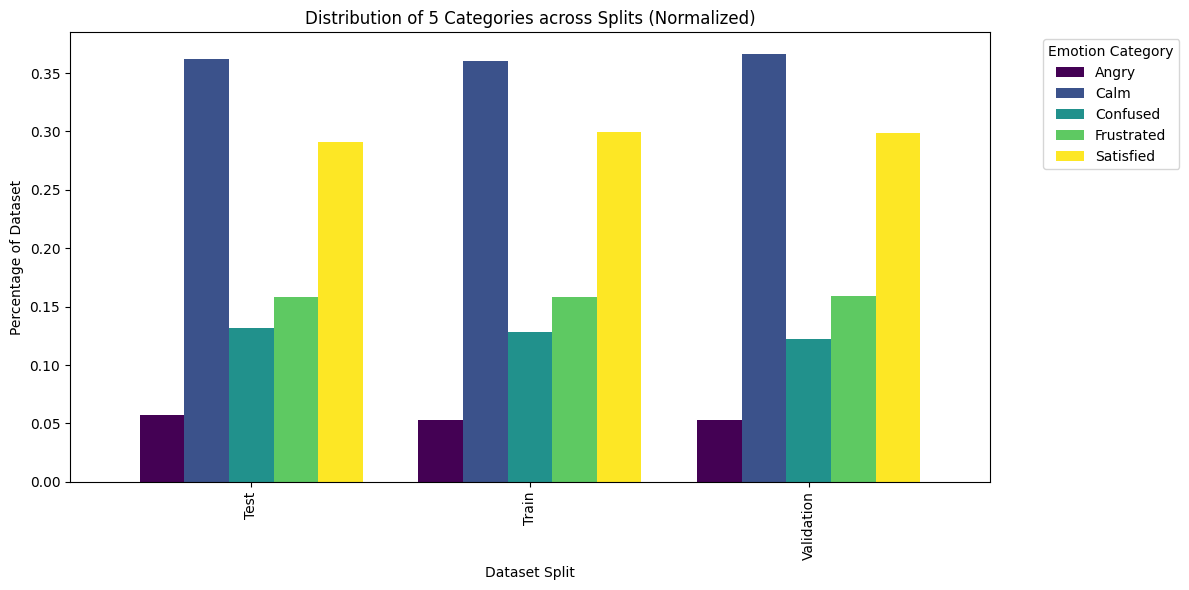

INSIGHT CHECK: Look at the bars. Are the 'Angry' bars roughly the same height in Train, Val, and Test? If Test has 50% Angry but Train only has 10%, our model will fail.


In [15]:
# Is it Balanced? (Train vs Test vs Val)
# We need to see if the (Test) is harder than the (Train)
df_train['split'] = 'Train'
df_val['split'] = 'Validation'
df_test['split'] = 'Test'

combined_df = pd.concat([df_train[['category_5', 'split']],
                         df_val[['category_5', 'split']],
                         df_test[['category_5', 'split']]])

plt.figure(figsize=(12, 6))
props = combined_df.groupby('split')['category_5'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked=False, width=0.8, colormap='viridis', figsize=(12,6))

plt.title("Distribution of 5 Categories across Splits (Normalized)")
plt.ylabel("Percentage of Dataset")
plt.xlabel("Dataset Split")
plt.legend(title="Emotion Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print("INSIGHT CHECK: Look at the bars. Are the 'Angry' bars roughly the same height in Train, Val, and Test? If Test has 50% Angry but Train only has 10%, our model will fail.")

**Insight:**  
The emotion category proportions are nearly identical across Train, Validation, and Test sets.  
This indicates that the data splitting preserved class distribution, ensuring fair model evaluation.  

Because no split is disproportionately skewed (e.g., more Angry in Test), performance metrics will reliably reflect real deployment behavior.


## Top Emojis by Emotion Category


/tmp/ipython-input-777198574.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['emojis'] = df_train['clean_text'].apply(extract_emojis)
/tmp/ipython-input-777198574.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['emojis'] = df_val['clean_text'].apply(extract_emojis)


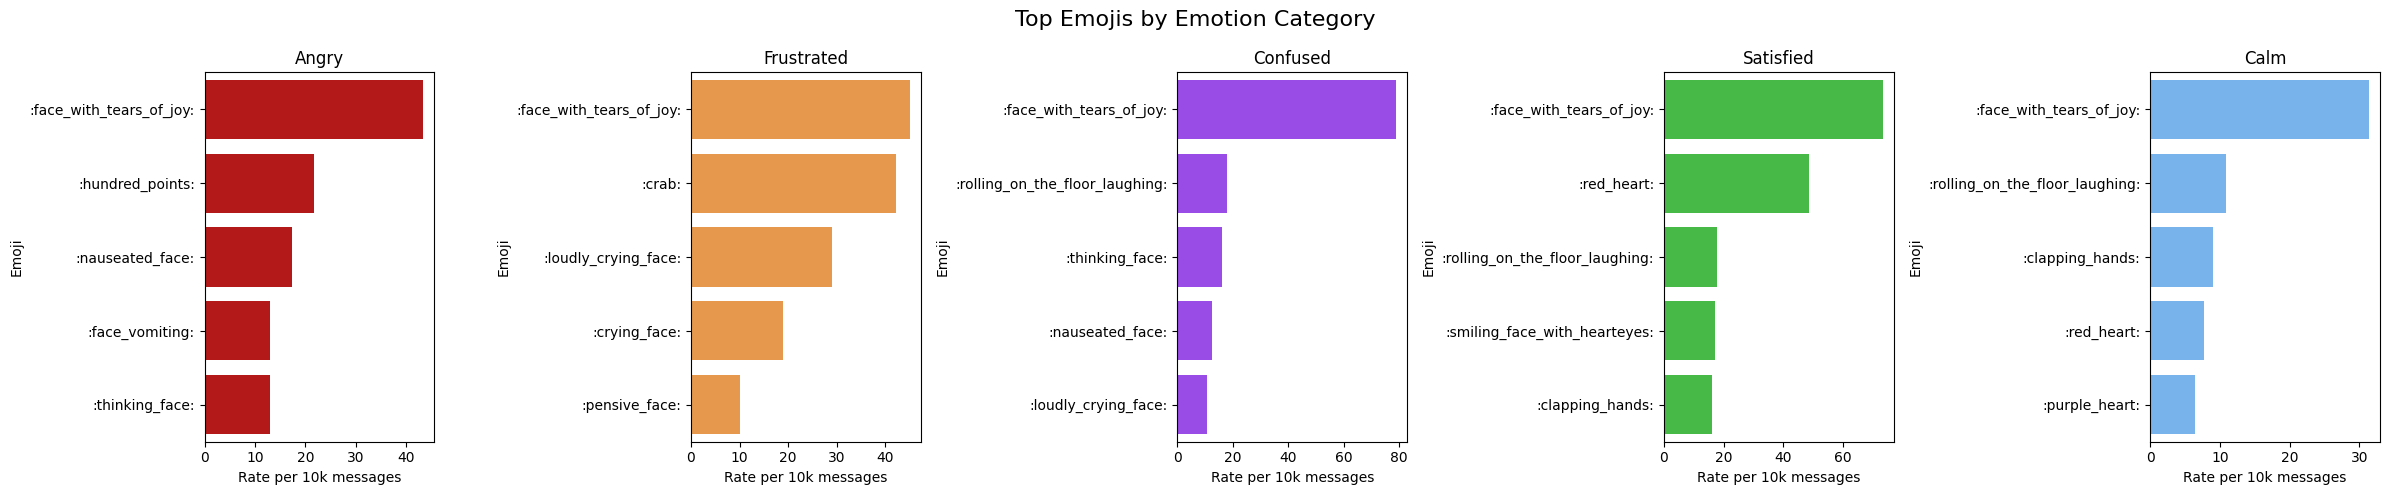

In [16]:
#Question: "Are emojis distinct markers for priority? Can we flag a ticket just because it has a 'skull' emoji?"
def extract_emojis(text):
    # Our cleaning kept emojis in the format :emoji_name:
    # This regex finds words wrapped in colons
    return re.findall(r':[a-z_]+:', text)

# Creating a column just for emojis for all dataframes
df_train['emojis'] = df_train['clean_text'].apply(extract_emojis)
df_val['emojis'] = df_val['clean_text'].apply(extract_emojis)
df_test['emojis'] = df_test['clean_text'].apply(extract_emojis)

# Emojis per 5 Categories
# Which emojis signal "Frustration" vs "Anger"?

emoji_counts_5 = {cat: Counter() for cat in ['Angry', 'Frustrated', 'Confused', 'Satisfied', 'Calm']}

for _, row in df_train.iterrows():
    cat = row['category_5']
    if row['emojis']:
        emoji_counts_5[cat].update(row['emojis'])

fig, axes = plt.subplots(1, 5, figsize=(24, 5))
categories = ['Angry', 'Frustrated', 'Confused', 'Satisfied', 'Calm']
colors = ['#cc0000', '#ff9933', '#9933ff', '#33cc33', '#66b3ff'] # Custom Palette

for i, cat in enumerate(categories):
    common = emoji_counts_5[cat].most_common(5)
    if common:
        emo_df = pd.DataFrame(common, columns=['Emoji', 'Count'])
        cat_size = (df_train['category_5'] == cat).sum()
        emo_df['Rate_per_10k'] = (emo_df['Count'] / cat_size) * 10000

        sns.barplot(x='Rate_per_10k', y='Emoji', data=emo_df, ax=axes[i], color=colors[i])
        axes[i].set_xlabel("Rate per 10k messages")

        axes[i].set_title(f'{cat}')
    else:
        axes[i].text(0.5, 0.5, "No Emojis", ha='center')

plt.suptitle("Top Emojis by Emotion Category", fontsize=16)
plt.tight_layout()
plt.show()

**Insight:**  
Emojis show distinct patterns across emotion categories.  
Negative emotions (Angry, Frustrated) frequently include intense or expressive emojis,  
while Calm and Satisfied categories contain more positive or neutral emojis.

This confirms that emojis carry strong emotional signal and should be preserved during preprocessing, as they can improve classification performance and priority detection.


## Common Phrases in Negative Messages

Analyzing the REASONS for Anger (Trigrams)...


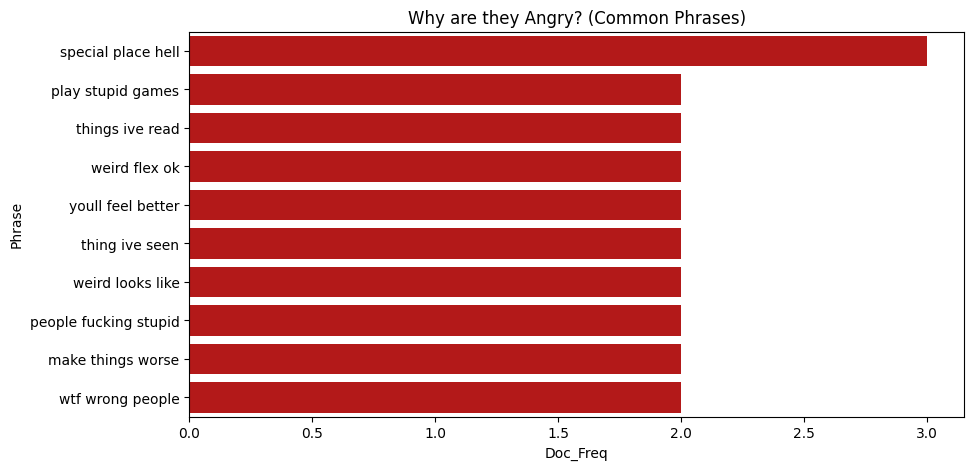

Analyzing the REASONS for Frustration...


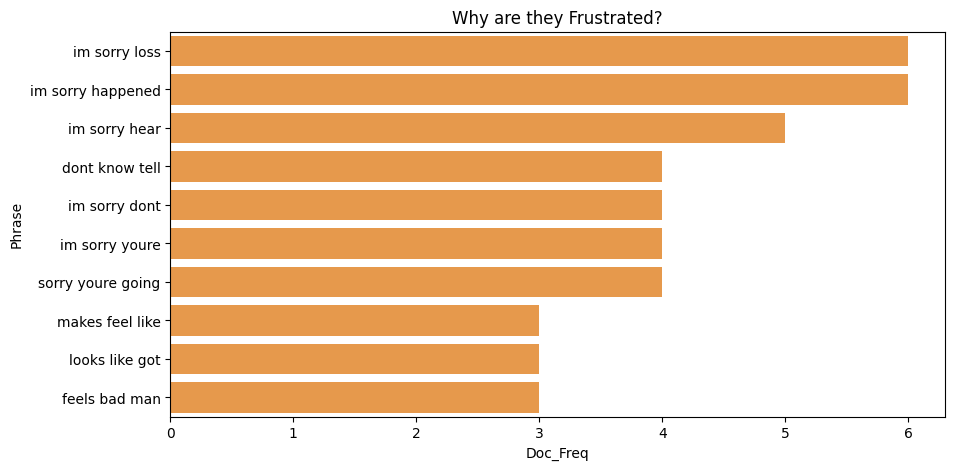

Analyzing the REASONS for Confusion...


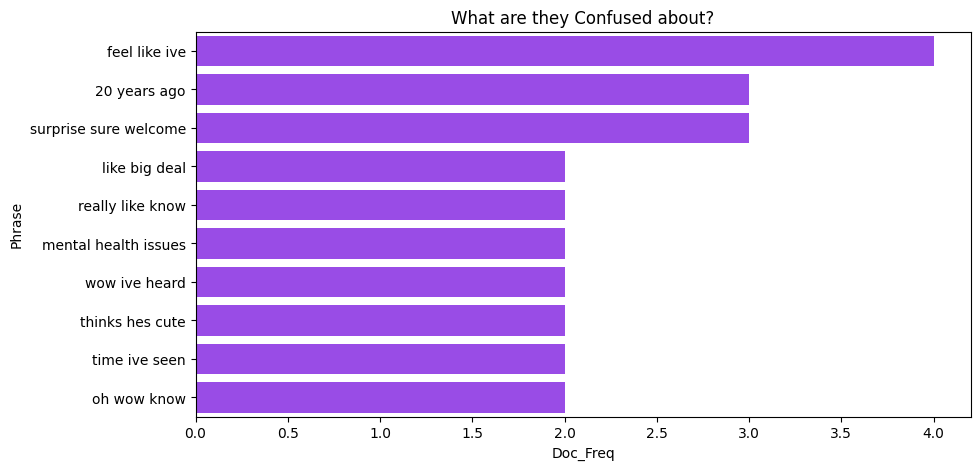


--- Causal Snippets (Mining 'Because') ---

[ANGRY] Customer Explanations:
 -> "Ignore him, he is a spiteful little rat who is mad because someone did something good and it reminds him how pathetic he is."
 -> ">How do you know I didn't Because you posted this dumbass post. And only someone who didn't would say that"
 -> "Omg [NAME] he’s there because you don’t listen. You ass!"
 -> "You’re right, republicans are worse because they have nukes."
 -> "Thanks for sharing, it really sucks that people would do this. I barely slept last night because I was so frustrated with the situation."

[FRUSTRATED] Customer Explanations:
 -> "It’s because he so consistently lies and states mistruths. Why keep listening to a dishonest idiot?"
 -> "Drives to work, realizes its a holiday because nobody answers their phones. Still stuck at work... nothing to do. We dont get paid holidays :("
 -> "For 3 months so far. I’m not sure because I never had any successful withdrawals yet."
 -> "Why was the discri

In [17]:
# Deep Reasoning Analysis

def plot_top_trigrams(category, color, title):
    text_data = df_train[df_train['category_5'] == category]['clean_text']

    # Using Trigrams (ngram_range=(3,3)) to capture "Context-Reason-Object"
    # min_df=2 removes rare typos to focus on common reasons
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english', min_df=2).fit(text_data)
    bag_of_words = vec.transform(text_data)
    doc_freq = (bag_of_words > 0).sum(axis=0)  # number of docs containing trigram
    words_freq = [(word, doc_freq[0, idx]) for word, idx in vec.vocabulary_.items()]


    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:10]
    df_trigram = pd.DataFrame(words_freq, columns=['Phrase', 'Doc_Freq'])

    plt.figure(figsize=(10, 5))
    sns.barplot(x='Doc_Freq', y='Phrase', data=df_trigram, color=color)
    plt.title(title)
    plt.show()

# Visualizing the Negative/Confused Categories (Where we need reasons)
print("Analyzing the REASONS for Anger (Trigrams)...")
plot_top_trigrams('Angry', '#cc0000', "Why are they Angry? (Common Phrases)")

print("Analyzing the REASONS for Frustration...")
plot_top_trigrams('Frustrated', '#ff9933', "Why are they Frustrated?")

print("Analyzing the REASONS for Confusion...")
plot_top_trigrams('Confused', '#9933ff', "What are they Confused about?")

# "Causal" Keyword Mining
# Find sentences that explicitly state the reason using "because"
print("\n--- Causal Snippets (Mining 'Because') ---")

def get_causal_snippets(category, num_samples=5):
    # Filter for the category
    subset = df_train[df_train['category_5'] == category]
    # Find rows containing "because"
    reasons = subset[subset['text'].str.contains(" because ", case=False, na=False)]['text']

    print(f"\n[{category.upper()}] Customer Explanations:")
    if len(reasons) > 0:
        for text in reasons.sample(min(len(reasons), num_samples)):
            print(f" -> \"{text}\"")
    else:
        print(" -> No explicit 'because' statements found.")

get_causal_snippets('Angry')
get_causal_snippets('Frustrated')

**Insight:**  
Angry messages contain aggressive or hostile phrasing, indicating direct dissatisfaction or blame.  
These expressions reflect high emotional intensity and support classifying Angry messages as high-priority for routing.

Frustrated messages often include complaint-driven or apologetic phrases, suggesting ongoing dissatisfaction rather than explosive anger.  
This indicates operational urgency, but typically lower intensity than Angry, supporting a medium-to-high priority assignment.

Confused messages contain clarification-seeking or uncertainty-related phrases.  
These indicate a need for guidance rather than escalation, making them suitable for routing to support or help-desk teams instead of high-priority complaint handling.

## Most Frequent Words by Emotion Category


Generating plot for Angry...
Generating plot for Frustrated...
Generating plot for Confused...
Generating plot for Satisfied...
Generating plot for Calm...


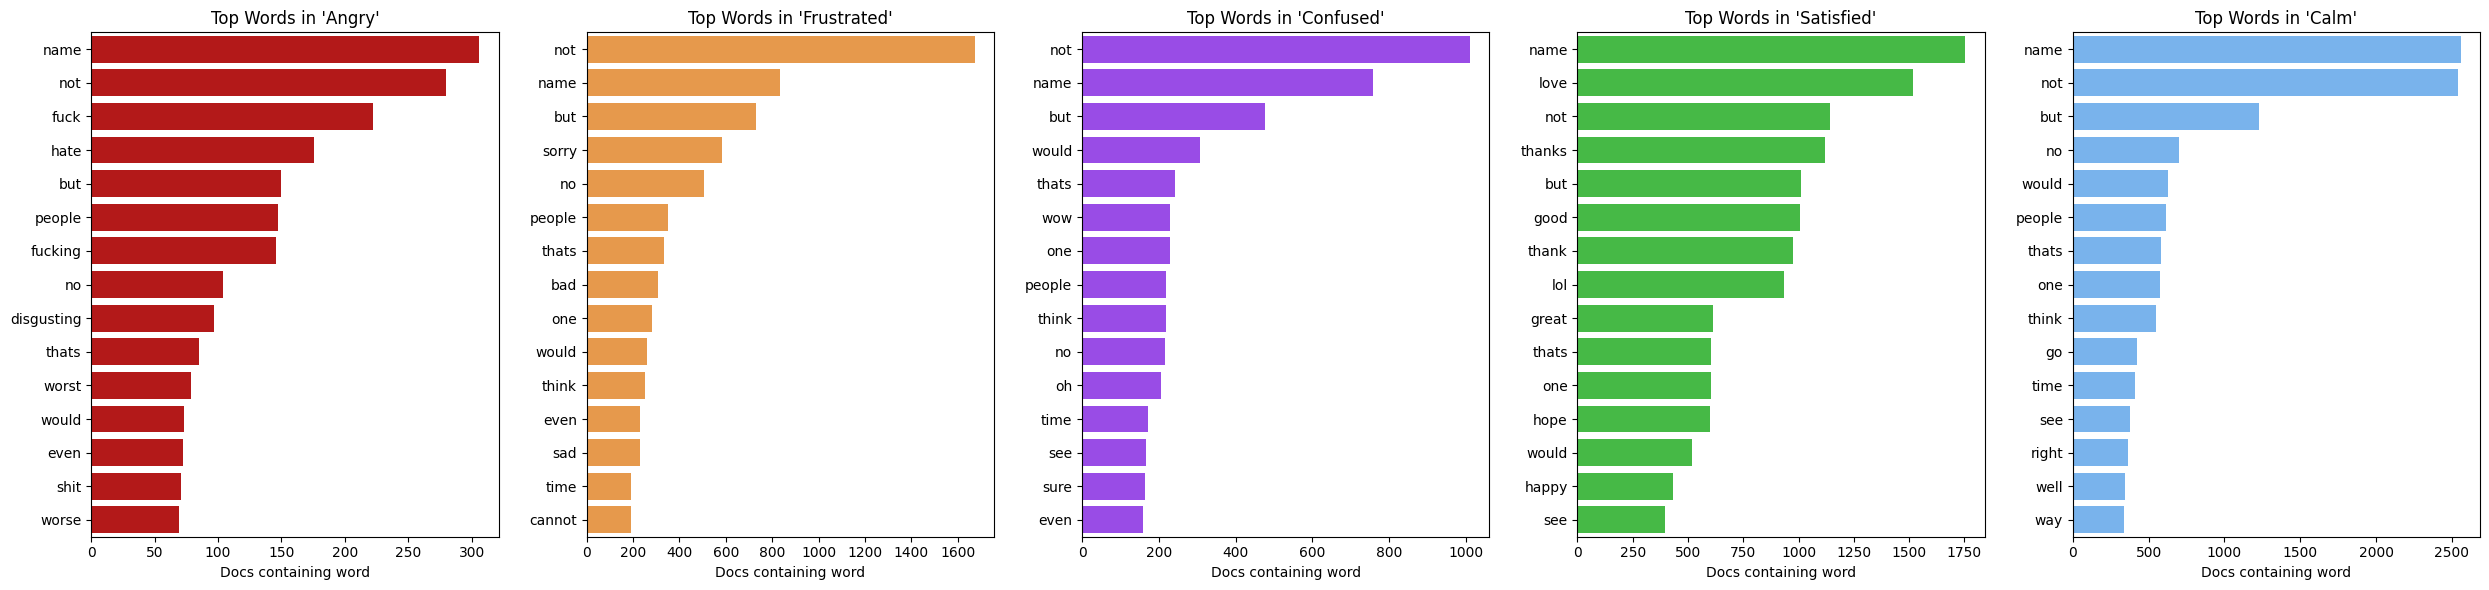

In [18]:
# Visualizing Top Words per Category

def plot_top_words(category, color, ax):
    # 1. Filter data for this specific category
    text_data = df_train[df_train['category_5'] == category]['clean_text']

    # 2. Safety Check: If data is empty, we skip
    if text_data.empty:
        return

    # 3. Vectorize (Count raw frequency)
    # We add 'custom_stop_words' to remove generic fluff like "im", "just", "like"
    # This reveals the REAL topics (e.g., "game", "money", "time")
    custom_stop = list(final_stop_words) + ['im', 'just', 'like', 'feel', 'dont', 'know', 'really', 'want', 'get']

    vec = CountVectorizer(stop_words=custom_stop, max_features=20).fit(text_data)
    bag_of_words = vec.transform(text_data)
    doc_freq = (bag_of_words > 0).sum(axis=0)
    words_freq = [(word, doc_freq[0, idx]) for word, idx in vec.vocabulary_.items()]


    # 4. Sort and get Top 15
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:15]
    df_words = pd.DataFrame(words_freq, columns=['Word', 'Doc_Freq'])

    # 5. Plot
    sns.barplot(x='Doc_Freq', y='Word', data=df_words, ax=ax, color=color)
    ax.set_title(f"Top Words in '{category}'")
    ax.set_xlabel("Docs containing word")
    ax.set_ylabel("")

# Create a huge canvas for 5 plots
fig, axes = plt.subplots(1, 5, figsize=(25, 6))
categories = ['Angry', 'Frustrated', 'Confused', 'Satisfied', 'Calm']
colors = ['#cc0000', '#ff9933', '#9933ff', '#33cc33', '#66b3ff'] # Red, Orange, Purple, Green, Blue

# Loop through and plot
for i, cat in enumerate(categories):
    print(f"Generating plot for {cat}...")
    plot_top_words(cat, colors[i], axes[i])

plt.tight_layout()
plt.show()

**Insight:**  
Each emotion category exhibits distinct vocabulary patterns.  

- Angry messages contain strong negative and offensive terms, reflecting high emotional intensity.
- Frustrated messages include dissatisfaction markers (e.g., “sorry”, “bad”), suggesting ongoing issues.
- Confused messages contain uncertainty-related words (e.g., “would”, “think”), indicating clarification needs.
- Satisfied messages show positive expressions (e.g., “love”, “thanks”), reflecting resolution or approval.
- Calm messages contain neutral conversational language.

These separable word patterns support the use of TF-IDF with linear classifiers, as the categories are lexically distinguishable.


## Priority Level Distribution Across Train, Validation, and Test Sets


/tmp/ipython-input-1050664614.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='priority', data=df_train, order=order, palette=palette, ax=axes[0])
/tmp/ipython-input-1050664614.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='priority', data=df_val, order=order, palette=palette, ax=axes[1])
/tmp/ipython-input-1050664614.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='priority', data=df_test, order=order, palette=palette, ax=axes[2])


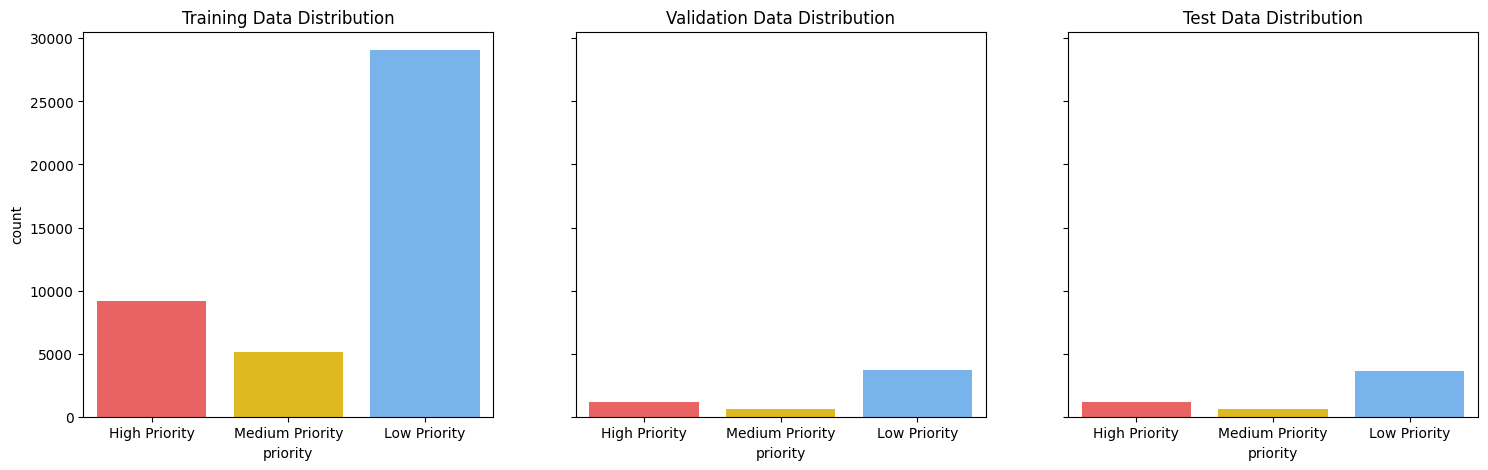

Insight: Ensure the bars look roughly similar across all three charts. If Test has way more High Priority than Train, our model will fail.


In [19]:
#Distribution Consistency Check
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
order = ['High Priority', 'Medium Priority', 'Low Priority']
palette = {'High Priority': '#ff4d4d', 'Medium Priority': '#ffcc00', 'Low Priority': '#66b3ff'}
sns.countplot(x='priority', data=df_train, order=order, palette=palette, ax=axes[0])
axes[0].set_title('Training Data Distribution')
sns.countplot(x='priority', data=df_val, order=order, palette=palette, ax=axes[1])
axes[1].set_title('Validation Data Distribution')
sns.countplot(x='priority', data=df_test, order=order, palette=palette, ax=axes[2])
axes[2].set_title('Test Data Distribution')
plt.show()
print("Insight: Ensure the bars look roughly similar across all three charts. If Test has way more High Priority than Train, our model will fail.")

**Insight:**  
Low-priority messages dominate across all splits, while High-priority messages form a smaller proportion of the dataset.

This imbalance means:
- A model could achieve high accuracy by favoring Low priority.
- Macro-F1 or class-sensitive evaluation is necessary.
- Misclassifying High-priority tickets would have a larger business impact despite their lower frequency.


## Common Phrases in High-Priority Tickets



Analyzing what creates High Priority tickets...


/tmp/ipython-input-2839737352.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Doc_Freq', y='Bigram', data=df_bigram, palette='Reds_r')


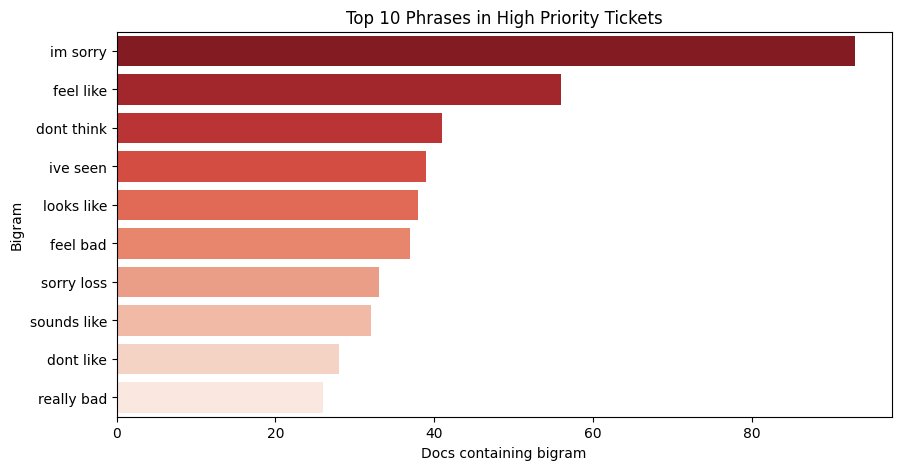

In [20]:
def plot_top_bigrams(text_data, title):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text_data)
    bag_of_words = vec.transform(text_data)
    doc_freq = (bag_of_words > 0).sum(axis=0)
    words_freq = [(word, doc_freq[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:10]

    df_bigram = pd.DataFrame(words_freq, columns=['Bigram', 'Doc_Freq'])
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Doc_Freq', y='Bigram', data=df_bigram, palette='Reds_r')
    plt.title(title)
    plt.xlabel("Docs containing bigram")
    plt.show()

print("\nAnalyzing what creates High Priority tickets...")
high_priority_text = df_train[df_train['priority'] == 'High Priority']['clean_text']
plot_top_bigrams(high_priority_text, "Top 10 Phrases in High Priority Tickets")

**Insight:**  
High-priority tickets frequently contain phrases expressing dissatisfaction, concern, or urgency (e.g., “feel bad”, “really bad”, “don’t like”).  

These patterns confirm that priority assignment is strongly tied to emotional intensity.  
It also suggests that phrase-level features (bigrams) improve detection of urgent cases beyond single-word signals.


## Emoji Distribution Across Priority Levels


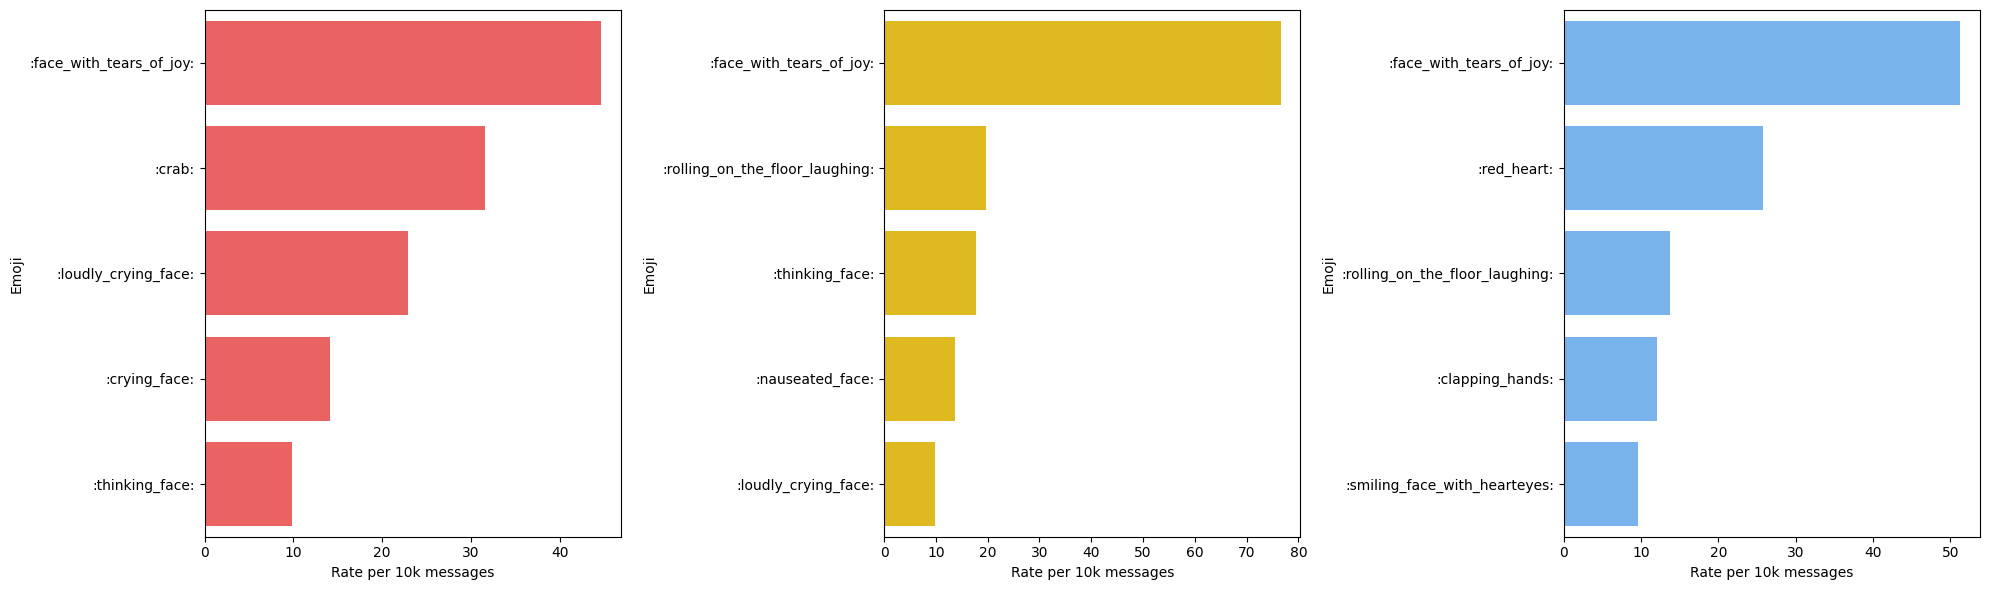

INSIGHT: If specific emojis like ':face_with_symbols_on_mouth:' appear ONLY in High Priority, we can create a 'Flag' feature for them.


In [21]:
# Count emojis per Priority Group
emoji_counts = {
    'High Priority': Counter(),
    'Medium Priority': Counter(),
    'Low Priority': Counter()
}

for _, row in df_train.iterrows():
    priority = row['priority']
    if row['emojis']:
        emoji_counts[priority].update(row['emojis'])

# Visualize Top Emojis
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
priorities = ['High Priority', 'Medium Priority', 'Low Priority']
colors = ['#ff4d4d', '#ffcc00', '#66b3ff'] # Red, Yellow, Blue

for i, priority in enumerate(priorities):
    # Get top 5 emojis
    common = emoji_counts[priority].most_common(5)
    if common:
        emo_df = pd.DataFrame(common, columns=['Emoji', 'Count'])
        prio_size = (df_train['priority'] == priority).sum()
        emo_df['Rate_per_10k'] = (emo_df['Count'] / prio_size) * 10000
        sns.barplot(x='Rate_per_10k', y='Emoji', data=emo_df, ax=axes[i], color=colors[i])
        axes[i].set_xlabel("Rate per 10k messages")
    else:
        axes[i].text(0.5, 0.5, "No Emojis Found", ha='center')

plt.tight_layout()
plt.show()
print("INSIGHT: If specific emojis like ':face_with_symbols_on_mouth:' appear ONLY in High Priority, we can create a 'Flag' feature for them.")

**Insight:**  
High-priority tickets show stronger presence of emotionally intense emojis (e.g., crying, loud crying),  
while lower-priority tickets contain more neutral or positive emojis (e.g., hearts, laughter).

This suggests emoji intensity correlates with urgency.  
Emoji-based features could serve as early indicators for high-priority routing decisions.


## Message Length vs. Priority Level


/tmp/ipython-input-2045540490.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['word_count'] = df_train['clean_text'].apply(lambda x: len(x.split()))
/tmp/ipython-input-2045540490.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='priority', y='word_count', data=df_train,


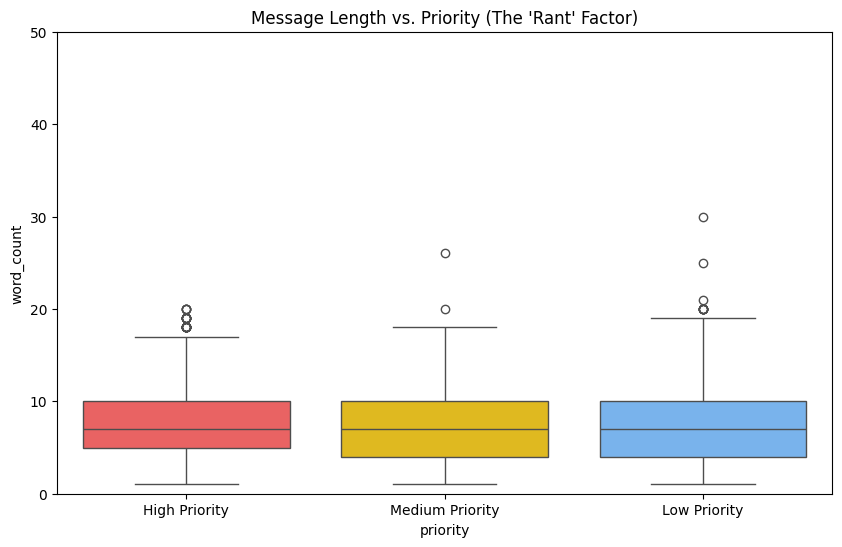

INSIGHT: Look at the median line (the line inside the box). If 'High Priority' is higher, it confirms that angry customers write more.


In [22]:
#Question: "Do angry customers write long essays (rants) while happy customers write short 'Thank yous'?"
# Calculate word count
df_train['word_count'] = df_train['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.boxplot(x='priority', y='word_count', data=df_train,
            order=['High Priority', 'Medium Priority', 'Low Priority'],
            palette={'High Priority': '#ff4d4d', 'Medium Priority': '#ffcc00', 'Low Priority': '#66b3ff'})

plt.title("Message Length vs. Priority (The 'Rant' Factor)")
plt.ylim(0, 50) # Limit y-axis to ignore extreme outliers for better readability
plt.show()
print("INSIGHT: Look at the median line (the line inside the box). If 'High Priority' is higher, it confirms that angry customers write more.")

**Insight:**  
Message length distributions are relatively similar across priority levels, with only slight variation in medians and spread.

This suggests that urgency is not strongly determined by message length alone.  
Emotional content and wording patterns are more informative features than text length for routing decisions.


## Key Drivers of High-Priority and Medium-Priority Tickets



--- Investigating High Priority Drivers ---


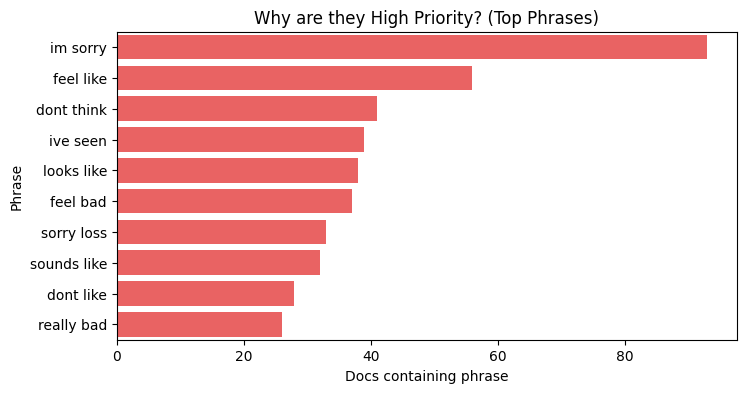


--- Investigating Medium Priority Drivers ---


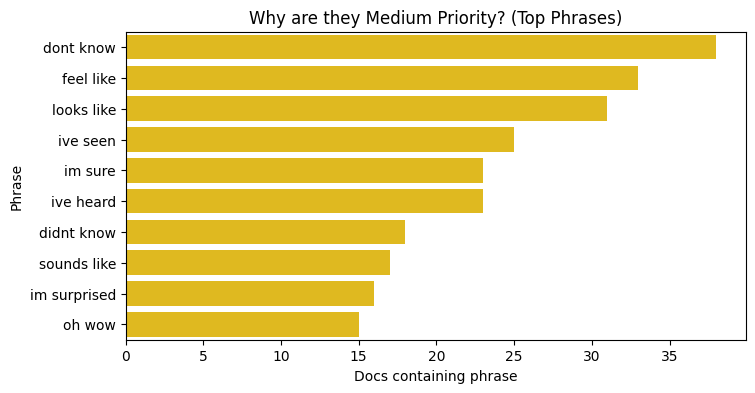

In [23]:
#Question: "We know they are angry. But why? Is it 'Bad Service' or 'Late Delivery'?"

def plot_distinctive_bigrams(priority_group, color):
    # Filter text for this specific group
    text_data = df_train[df_train['priority'] == priority_group]['clean_text']

    # Use Bigrams (2 words)
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text_data)
    bag_of_words = vec.transform(text_data)
    doc_freq = (bag_of_words > 0).sum(axis=0)
    words_freq = [(word, doc_freq[0, idx]) for word, idx in vec.vocabulary_.items()]


    # Sort and take top 10
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)[:10]
    df_bigram = pd.DataFrame(words_freq, columns=['Phrase', 'Doc_Freq'])

    # Plot
    plt.figure(figsize=(8, 4))
    sns.barplot(x='Doc_Freq', y='Phrase', data=df_bigram, color=color)
    plt.xlabel("Docs containing phrase")
    plt.title(f"Why are they {priority_group}? (Top Phrases)")
    plt.show()

# Run for High and Medium (Low is usually less actionable)
print(f"\n--- Investigating High Priority Drivers ---")
plot_distinctive_bigrams('High Priority', '#ff4d4d')

print(f"\n--- Investigating Medium Priority Drivers ---")
plot_distinctive_bigrams('Medium Priority', '#ffcc00')

**Insight:**  
High-priority tickets contain strong dissatisfaction phrases (e.g., “feel bad”, “really bad”, “don’t like”), indicating emotional intensity and negative experience.

These expressions justify escalation and support mapping high-intensity language directly to urgent routing decisions.

Medium-priority tickets contain uncertainty and clarification-related phrases (e.g., “don’t know”, “feel like”, “looks like”).

This suggests these messages reflect unresolved issues or confusion rather than direct anger, making them suitable for standard support handling rather than escalation.



## Emotion Co-occurrence Patterns


/tmp/ipython-input-4242098669.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['emotion_names'] = df_train['labels'].apply(lambda x: [emotion_names[i] for i in x])


Top co-occurring emotion pairs (by count):
admiration + gratitude: 279
anger + annoyance: 269
admiration + approval: 246
confusion + curiosity: 212
approval + neutral: 202
admiration + love: 192
annoyance + disapproval: 178
disappointment + sadness: 133
annoyance + neutral: 132
admiration + joy: 126
curiosity + neutral: 117
annoyance + disappointment: 110
disapproval + neutral: 109
admiration + optimism: 106
approval + optimism: 100
confusion + neutral: 98
admiration + neutral: 94
amusement + joy: 90
caring + optimism: 90
excitement + joy: 86


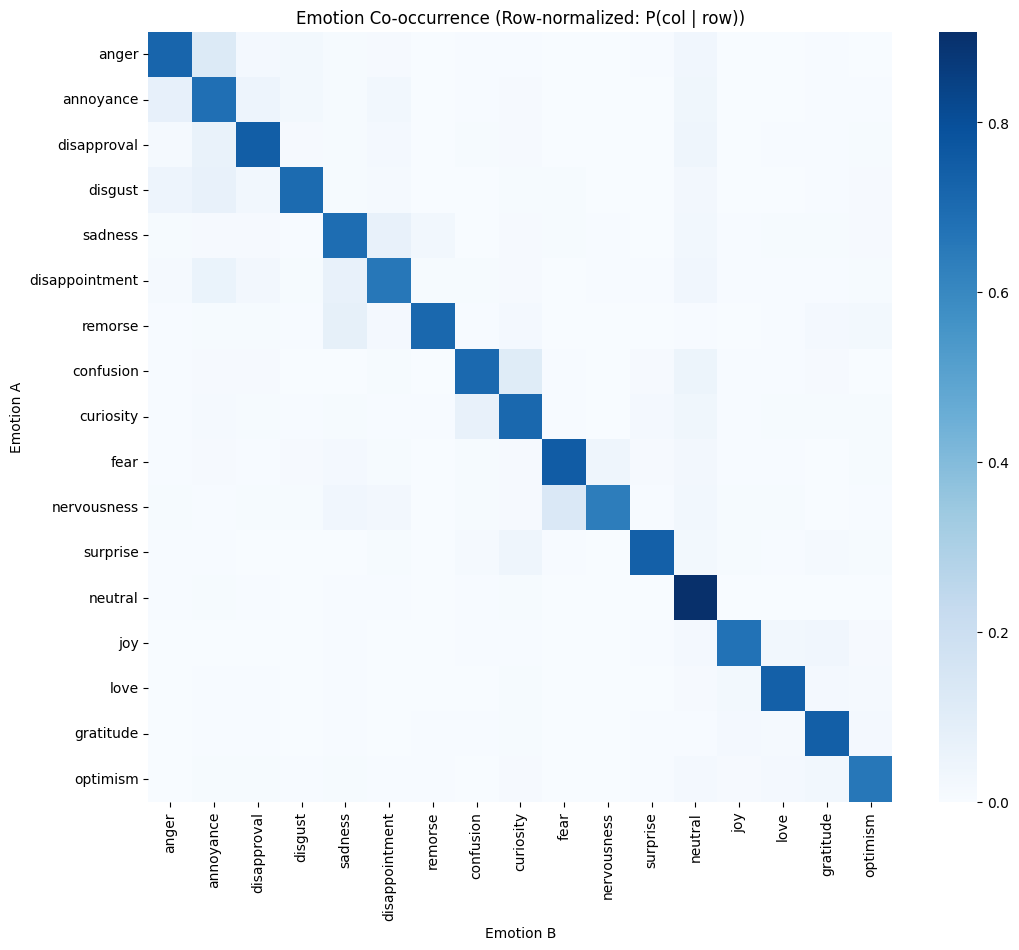

In [24]:
# 1. Convert list of indices to list of names
# We use the raw 27 emotions here to see fine-grained detail
df_train['emotion_names'] = df_train['labels'].apply(lambda x: [emotion_names[i] for i in x])

# 2. One-Hot Encode
mlb = MultiLabelBinarizer()
emotion_matrix = mlb.fit_transform(df_train['emotion_names'])
emotion_df = pd.DataFrame(emotion_matrix, columns=mlb.classes_)
E = emotion_df.values.astype(int)  # shape: [n_samples, n_emotions]
labels = emotion_df.columns.tolist()

# Raw co-occurrence counts
co_counts = E.T @ E
co_counts_df = pd.DataFrame(co_counts, index=labels, columns=labels)

# Normalize to "given A, probability of B" = P(B|A)
row_sums = co_counts_df.sum(axis=1).replace(0, 1)
co_prob_df = co_counts_df.div(row_sums, axis=0)

# Show top pairings (exclude diagonal)
pairs = []
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        pairs.append((labels[i], labels[j], co_counts_df.iat[i, j]))
top_pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:20]
print("Top co-occurring emotion pairs (by count):")
for a, b, c in top_pairs:
    print(f"{a} + {b}: {c}")

# Plot a focused heatmap for a subset
focus = ['anger','annoyance','disapproval','disgust','sadness','disappointment','remorse',
         'confusion','curiosity','fear','nervousness','surprise','neutral','joy','love','gratitude','optimism']

focus = [x for x in focus if x in labels]
plt.figure(figsize=(12, 10))
sns.heatmap(co_prob_df.loc[focus, focus], cmap='Blues', annot=False)
plt.title("Emotion Co-occurrence (Row-normalized: P(col | row))")
plt.xlabel("Emotion B")
plt.ylabel("Emotion A")
plt.show()


**Insight:**  
Certain emotions frequently co-occur (e.g., anger with annoyance or disapproval), while positive emotions cluster together (joy, love, gratitude).

This overlap explains why some categories may be difficult to separate perfectly during classification.  
Grouping fine-grained emotions into broader operational categories reduces this ambiguity and improves routing stability.


## UMAP Projection of Sentence Embeddings by Emotion Category


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


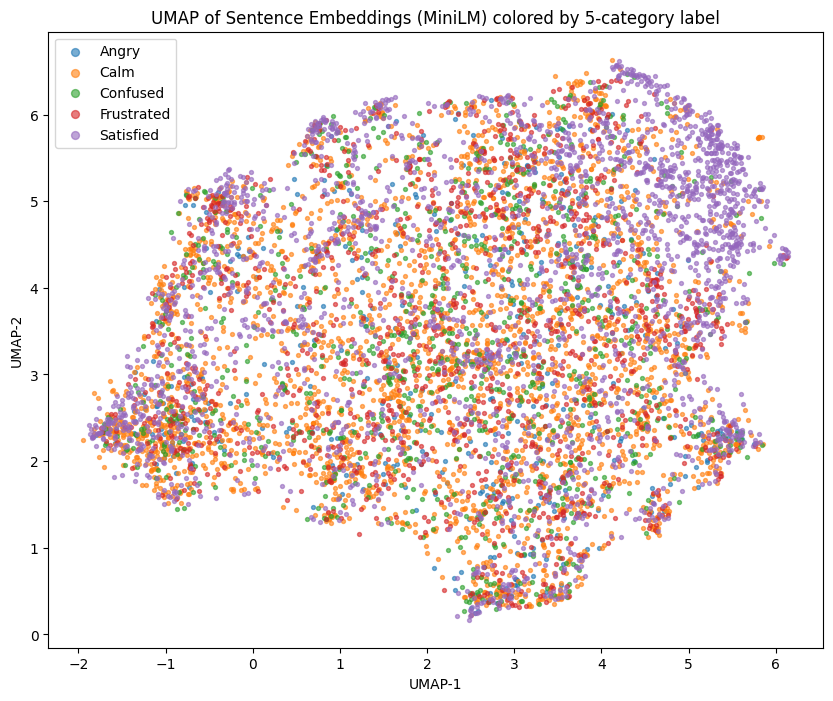

In [25]:
# Embedding Visualization
N = 8000
viz_df = df_train.sample(min(N, len(df_train)), random_state=42).copy()

texts = viz_df['text'].tolist()
labels_5 = viz_df['category_5'].tolist()

model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(texts, batch_size=64, show_progress_bar=True, normalize_embeddings=True)

reducer = umap.UMAP(n_neighbors=25, min_dist=0.1, metric="cosine", random_state=42)
xy = reducer.fit_transform(emb)

viz_df["x"] = xy[:, 0]
viz_df["y"] = xy[:, 1]

plt.figure(figsize=(10, 8))
for lab in sorted(viz_df["category_5"].unique()):
    subset = viz_df[viz_df["category_5"] == lab]
    plt.scatter(subset["x"], subset["y"], s=8, alpha=0.6, label=lab)

plt.title("UMAP of Sentence Embeddings (MiniLM) colored by 5-category label")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(markerscale=2)
plt.show()


**Insight:**  
The emotion categories show partial clustering but also significant overlap in the embedding space.

This indicates:
- Emotional signals are present and somewhat learnable.
- Boundaries between categories (e.g., Angry vs. Frustrated) are not perfectly separable.
- Some classification errors are expected due to semantic overlap.

This reinforces the need for robust evaluation and possibly more expressive models for finer separation.


In [26]:
# In GoEmotions, 'neutral' is a label, but sometimes lists are empty []
df_train['label_count'] = df_train['labels'].apply(len)
unlabeled_rows = df_train[df_train['label_count'] == 0]

print(f"Total Unlabeled Rows: {len(unlabeled_rows)}")

if len(unlabeled_rows) > 0:
    print("\n--- Sample of Unlabeled Content ---")
    # Let's see what these 'Ghost' tickets look like
    for text in unlabeled_rows['text'].head(5):
        print(f" -> {text}")
    print("\nDECISION: If these look like junk, we drop them. If they look real, we might map them to 'Neutral'.")
else:
    print("Great! All rows have at least one label. No data quality issues here.")

Total Unlabeled Rows: 0
Great! All rows have at least one label. No data quality issues here.


/tmp/ipython-input-2683354263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['label_count'] = df_train['labels'].apply(len)


# Model Training and Evaluation

In this phase, text data is transformed using TF-IDF features and evaluated using linear classifiers.

Logistic Regression and Linear SVM are compared to determine which model better separates the operational emotion categories.

Evaluation focuses on Macro-F1 to ensure balanced performance across all priority-sensitive classes.


In [27]:
X_train = df_train['clean_text']
y_train = df_train['category_5']
print("Train distribution (raw):")
print(y_train.value_counts())
print("\nTrain distribution (percent):")
print((y_train.value_counts(normalize=True) * 100).round(2))
X_val = df_val['clean_text']
y_val = df_val['category_5']

X_test = df_test['clean_text']
y_test = df_test['category_5']

Train distribution (raw):
category_5
Calm          15604
Satisfied     12983
Frustrated     6878
Confused       5577
Angry          2307
Name: count, dtype: int64

Train distribution (percent):
category_5
Calm          36.00
Satisfied     29.95
Frustrated    15.87
Confused      12.87
Angry          5.32
Name: proportion, dtype: float64


In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
sampler = RandomOverSampler(random_state=42)

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('sampler', sampler),
    # Oversampling already balances the training set, so class_weight is optional.
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('sampler', sampler),
    ('clf', LinearSVC(dual='auto', random_state=42))
])

pipeline_sgd = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('sampler', sampler),
    ('clf', SGDClassifier(random_state=42))
])

pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=50000, ngram_range=(1,2), norm=None)),
    ('sampler', sampler),
    ('clf', ComplementNB(alpha=0.5))
])



In [30]:
print("Training Logistic Regression...")
pipeline_lr.fit(X_train, y_train)

y_train_pred_lr = pipeline_lr.predict(X_train)
train_f1_lr = f1_score(y_train, y_train_pred_lr, average='macro')

y_val_pred_lr = pipeline_lr.predict(X_val)
val_f1_lr = f1_score(y_val, y_val_pred_lr, average='macro')

print(f"LogReg Macro-F1 | Train: {train_f1_lr:.4f} | Val: {val_f1_lr:.4f}")
score_lr = val_f1_lr


Training Logistic Regression...
LogReg Macro-F1 | Train: 0.6608 | Val: 0.5295


In [31]:
print("Training Linear SVM...")
pipeline_svm.fit(X_train, y_train)

y_train_pred_svm = pipeline_svm.predict(X_train)
train_f1_svm = f1_score(y_train, y_train_pred_svm, average='macro')

y_val_pred_svm = pipeline_svm.predict(X_val)
val_f1_svm = f1_score(y_val, y_val_pred_svm, average='macro')

print(f"SVM Macro-F1    | Train: {train_f1_svm:.4f} | Val: {val_f1_svm:.4f}")
score_svm = val_f1_svm


Training Linear SVM...
SVM Macro-F1    | Train: 0.6711 | Val: 0.5069


In [32]:
X_tmp = pipeline_svm.named_steps['tfidf'].fit_transform(X_train)
y_tmp = y_train.copy()
X_res, y_res = RandomOverSampler(random_state=42).fit_resample(X_tmp, y_tmp)
print("\nAfter oversampling (should be equal counts):")
print(pd.Series(y_res).value_counts())



After oversampling (should be equal counts):
category_5
Calm          15604
Angry         15604
Confused      15604
Frustrated    15604
Satisfied     15604
Name: count, dtype: int64


In [33]:
if score_svm > score_lr:
    best_model = pipeline_svm
    model_name = "Linear SVM"
else:
    best_model = pipeline_lr
    model_name = "Logistic Regression"

print(f"\n WINNER: {model_name} (Proceeding to Optimization)")


 WINNER: Logistic Regression (Proceeding to Optimization)


In [34]:
# Better hyperparameter tuning
# Tunes TF-IDF + model together, uses stronger CV, and is faster than large GridSearch.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Candidate 1: Linear SVM
param_dist_svm = {
    'tfidf__max_features': [5000, 10000, 20000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [2, 3, 5],
    'tfidf__max_df': [0.8, 0.9, 1.0],
    'tfidf__sublinear_tf': [True, False],
    'clf__C': [0.1, 0.3, 1, 3, 10]
}

search_svm = RandomizedSearchCV(
    pipeline_svm,
    param_distributions=param_dist_svm,
    n_iter=30,
    cv=cv,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
search_svm.fit(X_train, y_train)

best_svm = search_svm.best_estimator_
best_svm_score = search_svm.best_score_
print("Best SVM params:", search_svm.best_params_)
print("Best SVM CV Macro-F1:", best_svm_score)


# Candidate 2: SGDClassifier
param_dist_sgd = {
    'tfidf__max_features': [5000, 10000, 20000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [2, 3, 5],
    'tfidf__max_df': [0.8, 0.9, 1.0],
    'tfidf__sublinear_tf': [True, False],
    'clf__loss': ['hinge', 'log_loss'],
    'clf__alpha': [1e-5, 1e-4, 1e-3],
    'clf__class_weight': [None, 'balanced'],
    'clf__max_iter': [3000]
}

search_sgd = RandomizedSearchCV(
    pipeline_sgd,
    param_distributions=param_dist_sgd,
    n_iter=30,
    cv=cv,
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
search_sgd.fit(X_train, y_train)

best_sgd = search_sgd.best_estimator_
best_sgd_score = search_sgd.best_score_
print("Best SGD params:", search_sgd.best_params_)
print("Best SGD CV Macro-F1:", best_sgd_score)


# Choose winner by CV Macro-F1
if best_sgd_score > best_svm_score:
    final_model = best_sgd
    print("WINNER: SGDClassifier")
else:
    final_model = best_svm
    print("WINNER: Linear SVM")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best SVM params: {'tfidf__sublinear_tf': True, 'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 2, 'tfidf__max_features': 10000, 'tfidf__max_df': 1.0, 'clf__C': 0.1}
Best SVM CV Macro-F1: 0.5281399003055376
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best SGD params: {'tfidf__sublinear_tf': True, 'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 5, 'tfidf__max_features': 10000, 'tfidf__max_df': 0.9, 'clf__max_iter': 3000, 'clf__loss': 'log_loss', 'clf__class_weight': None, 'clf__alpha': 0.0001}
Best SGD CV Macro-F1: 0.5344106147229691
WINNER: SGDClassifier


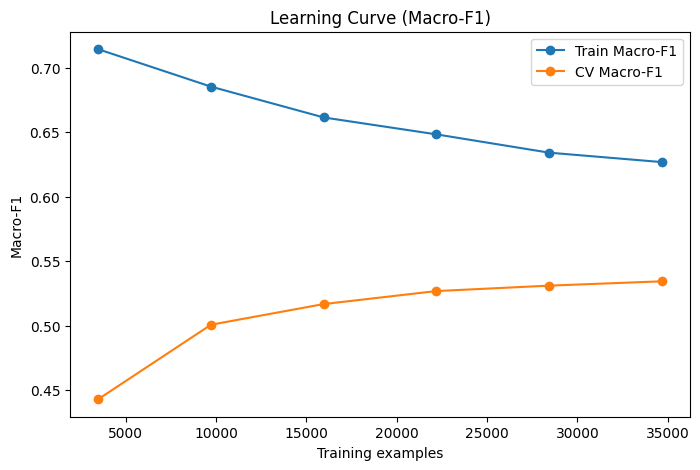

In [35]:
# Learning Curve (Macro-F1)


train_sizes, train_scores, val_scores = learning_curve(
    final_model,
    X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 6),
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, marker='o', label='Train Macro-F1')
plt.plot(train_sizes, val_mean, marker='o', label='CV Macro-F1')
plt.title("Learning Curve (Macro-F1)")
plt.xlabel("Training examples")
plt.ylabel("Macro-F1")
plt.legend()
plt.show()


--- FINAL REPORT: Logistic Regression ---
              precision    recall  f1-score   support

       Angry       0.39      0.61      0.47       312
        Calm       0.62      0.60      0.61      1962
    Confused       0.41      0.45      0.43       712
  Frustrated       0.45      0.43      0.44       859
   Satisfied       0.81      0.73      0.77      1576

    accuracy                           0.59      5421
   macro avg       0.53      0.56      0.54      5421
weighted avg       0.61      0.59      0.60      5421

Angry Recall (Risk Catch Rate): 0.6058


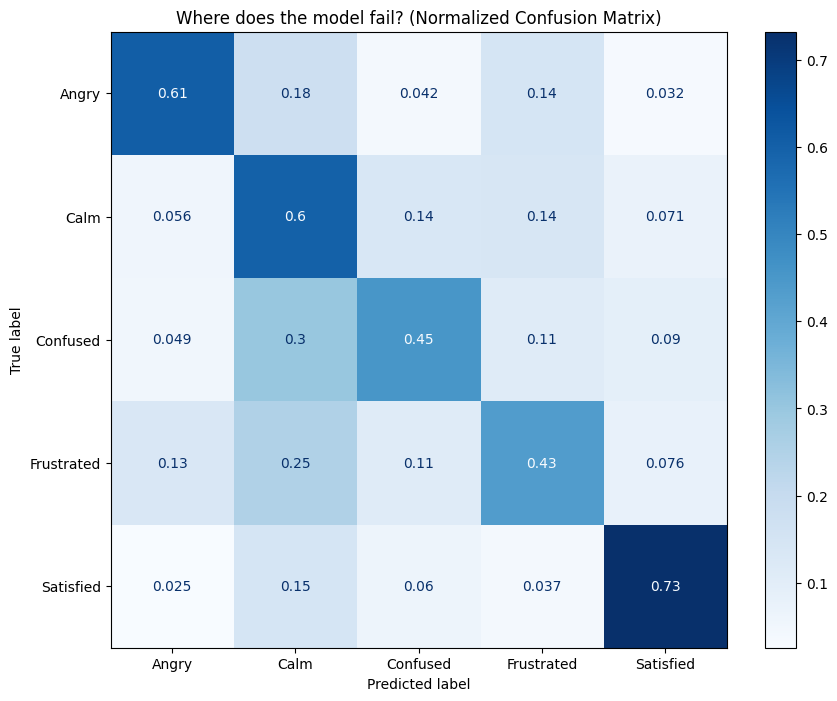

INSIGHT: Check the 'Angry' Box on the diagonal. If it's > 0.60, we are catching 60% of risks. In text analysis, that is often considered 'Good' for 5 classes.
TEST Macro-F1: 0.5440555759466253
TEST Weighted-F1: 0.5972085929583386


In [36]:
y_pred = final_model.predict(X_test)

# 1. Classification Report
print(f"--- FINAL REPORT: {model_name} ---")
print(classification_report(y_test, y_pred))

angry_recall = recall_score(y_test, y_pred, labels=['Angry'], average=None)[0]
print(f"Angry Recall (Risk Catch Rate): {angry_recall:.4f}")

# 2. Visual Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))
# Normalize='true' gives percentages, which is easier to understand
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', normalize='true')
plt.title("Where does the model fail? (Normalized Confusion Matrix)")
plt.show()

print("INSIGHT: Check the 'Angry' Box on the diagonal. If it's > 0.60, we are catching 60% of risks. In text analysis, that is often considered 'Good' for 5 classes.")

print("TEST Macro-F1:", f1_score(y_test, y_pred, average='macro'))
print("TEST Weighted-F1:", f1_score(y_test, y_pred, average='weighted'))

In [37]:
# Extract the vocabulary
feature_names = final_model.named_steps['tfidf'].get_feature_names_out()

# Get model coefficients
if model_name == "Linear SVM":
    coefs = final_model.named_steps['clf'].coef_
    classes = final_model.named_steps['clf'].classes_
elif model_name == "Logistic Regression":
    coefs = final_model.named_steps['clf'].coef_
    classes = final_model.named_steps['clf'].classes_

# Find the index for 'Angry'
angry_index = list(classes).index('Angry')
angry_coefs = coefs[angry_index]

# Get Top 15 Words driving "Angry"
top_indices = np.argsort(angry_coefs)[-15:]
print("--- 🚨 The 'Danger Words' (Top triggers for Angry) ---")
for i in top_indices:
    print(f"Word: '{feature_names[i]}' \t Weight: {angry_coefs[i]:.2f}")

--- 🚨 The 'Danger Words' (Top triggers for Angry) ---
Word: 'bitch' 	 Weight: 3.08
Word: 'stupid' 	 Weight: 3.41
Word: 'nasty' 	 Weight: 3.55
Word: 'shut' 	 Weight: 3.56
Word: 'hell' 	 Weight: 3.57
Word: 'weird' 	 Weight: 3.82
Word: 'dare' 	 Weight: 4.00
Word: 'angry' 	 Weight: 4.11
Word: 'worse' 	 Weight: 4.84
Word: 'worst' 	 Weight: 5.23
Word: 'awful' 	 Weight: 5.24
Word: 'fucking' 	 Weight: 5.30
Word: 'hate' 	 Weight: 6.12
Word: 'fuck' 	 Weight: 6.56
Word: 'disgusting' 	 Weight: 6.72


In [38]:
def predict_priority(text):
    # 1. Clean using Phase 1 logic
    clean = clean_text_professional(text)

    # 2. Predict
    pred = final_model.predict([clean])[0]

    # 3. Business Routing Logic
    actions = {
        'Angry': "🔴 URGENT: Route to Senior Agent (Risk Team)",
        'Frustrated': "🟠 HIGH: Route to Retention Team",
        'Confused': "🟣 MEDIUM: Route to Support/Education",
        'Satisfied': "🟢 LOW: Auto-Reply 'Thank you'",
        'Calm': "🔵 STANDARD: General Queue"
    }

    return pred, actions.get(pred, "Review")

# --- LIVE TEST ---
test_messages = [
    "I have been waiting for 3 hours! This is ridiculous.",
    "I love the new update, great job team!",
    "Can you tell me how to reset my password?",
    "The app crashes when I click the blue button.",
    "I am never using this service again. Refund me now."
]

print("---!!! SIMULATION !!!---")
for msg in test_messages:
    priority, action = predict_priority(msg)
    print(f"Input: \"{msg}\"")
    print(f"Detected: {priority}")
    print(f"Action: {action}")
    print("-" * 50)

---!!! SIMULATION !!!---
Input: "I have been waiting for 3 hours! This is ridiculous."
Detected: Angry
Action: 🔴 URGENT: Route to Senior Agent (Risk Team)
--------------------------------------------------
Input: "I love the new update, great job team!"
Detected: Satisfied
Action: 🟢 LOW: Auto-Reply 'Thank you'
--------------------------------------------------
Input: "Can you tell me how to reset my password?"
Detected: Calm
Action: 🔵 STANDARD: General Queue
--------------------------------------------------
Input: "The app crashes when I click the blue button."
Detected: Calm
Action: 🔵 STANDARD: General Queue
--------------------------------------------------
Input: "I am never using this service again. Refund me now."
Detected: Confused
Action: 🟣 MEDIUM: Route to Support/Education
--------------------------------------------------


In [39]:
print(classification_report(y_test, y_pred))
print("TEST Macro-F1:", f1_score(y_test, y_pred, average='macro'))
print("TEST Weighted-F1:", f1_score(y_test, y_pred, average='weighted'))
print("Angry Recall (Risk Catch Rate):", angry_recall)
print("TEST Accuracy:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

       Angry       0.39      0.61      0.47       312
        Calm       0.62      0.60      0.61      1962
    Confused       0.41      0.45      0.43       712
  Frustrated       0.45      0.43      0.44       859
   Satisfied       0.81      0.73      0.77      1576

    accuracy                           0.59      5421
   macro avg       0.53      0.56      0.54      5421
weighted avg       0.61      0.59      0.60      5421

TEST Macro-F1: 0.5440555759466253
TEST Weighted-F1: 0.5972085929583386
Angry Recall (Risk Catch Rate): 0.6057692307692307
TEST Accuracy: 0.5921416712783619
